In [20]:
import pandas as pd
import os
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import shap
import plotly.express as px

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


In [3]:
def string_to_float(string):
    try:
        # Rimuove le parentesi quadre e converte la stringa in float
        return float(string.strip('[]'))
    except ValueError:
        return np.nan


In [4]:
file_list_e = ['/lustrehome/mbossa/Nuses/Analysis/e-Mono_20GeV_onAxis_20000_evts/NUSES_wt_CaloHERDe-Mono_20000-0.25_onAxis_20000-evt-0', '/lustrehome/mbossa/Nuses/Analysis/e-Mono_20GeV_onAxis_20000_evts/NUSES_wt_CaloHERDe-Mono_20000-0.25_onAxis_20000-evt-1', '/lustrehome/mbossa/Nuses/Analysis/e-Mono_20GeV_onAxis_20000_evts/NUSES_wt_CaloHERDe-Mono_20000-0.25_onAxis_20000-evt-2', '/lustrehome/mbossa/Nuses/Analysis/e-Mono_20GeV_onAxis_20000_evts/NUSES_wt_CaloHERDe-Mono_20000-0.25_onAxis_20000-evt-3', '/lustrehome/mbossa/Nuses/Analysis/e-Mono_20GeV_onAxis_20000_evts/NUSES_wt_CaloHERDe-Mono_20000-0.25_onAxis_20000-evt-4']
file_list_p = ['/lustrehome/mbossa/Nuses/Analysis/protonMono_20GeV_onAxis_20000_evts/NUSES_wt_CaloHERDprotonMono_20000-0.25_onAxis_20000-evt-0', '/lustrehome/mbossa/Nuses/Analysis/protonMono_20GeV_onAxis_20000_evts/NUSES_wt_CaloHERDprotonMono_20000-0.25_onAxis_20000-evt-1', '/lustrehome/mbossa/Nuses/Analysis/protonMono_20GeV_onAxis_20000_evts/NUSES_wt_CaloHERDprotonMono_20000-0.25_onAxis_20000-evt-3', '/lustrehome/mbossa/Nuses/Analysis/protonMono_20GeV_onAxis_20000_evts/NUSES_wt_CaloHERDprotonMono_20000-0.25_onAxis_20000-evt-4']

In [6]:
df_list_e = [pd.read_csv(file) for file in file_list_e]
combined_df_e = pd.concat(df_list_e, ignore_index=True)

df_list_p = [pd.read_csv(file) for file in file_list_p]
combined_df_p = pd.concat(df_list_p, ignore_index=True)

combined_df_e['y_true'] = 0
combined_df_p['y_true'] = 1


In [7]:
for df in [combined_df_e, combined_df_p]:
    # Applica string_to_float alle colonne specificate
    df['R1'] = df['R1'].apply(string_to_float)
    df['R2'] = df['R2'].apply(string_to_float)
    df['R4'] = df['R4'].apply(string_to_float)
    df['R5'] = df['R5'].apply(string_to_float)
    df['R6'] = df['R6'].apply(string_to_float)
    df['R3'] = df['R3'].apply(lambda x: eval(x) if isinstance(x, str) else np.nan)
    
    # Crea colonne per R3
    for i in range(25):
        df[f'R3_{i+1}'] = df['R3'].apply(lambda x: x[i] if isinstance(x, list) and i < len(x) else 0)
    
    # Drop R3 column
    df.drop(columns=['R3'], inplace=True)
    
    # Converte tutte le colonne in numeriche
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Combina i dati di elettroni e protoni
combined_df = pd.concat([combined_df_e, combined_df_p], ignore_index=True)

# Rimozione delle righe con valori NaN
combined_df.dropna(inplace=True)

# Salva i dati senza etichette di colonne
combined_df.to_csv('combined_data_no_labels.csv', header=False, index=False)

# Caricamento dei dati senza etichette
numerical_data = np.loadtxt('combined_data_no_labels.csv', delimiter=',')

In [8]:
print(combined_df)

           Ev        R1        R2          R4     R5     R6  y_true      R3_1  \
0           0  0.000213  0.250018  149.757654  540.0 -150.0       0  0.021334   
1           1  0.000202  0.264842  133.739758  480.0 -150.0       0  0.023375   
2           2  0.000040  0.244061   94.099354  570.0 -150.0       0  0.028715   
3           3  0.000026  0.261706  107.577106  510.0 -120.0       0  0.021476   
4           4  0.000092  0.293526   89.096823  540.0 -150.0       0  0.041287   
...       ...       ...       ...         ...    ...    ...     ...       ...   
179995  19995  0.003669  0.182981  350.979583  750.0  -90.0       1  0.182981   
179996  19996  0.141352  0.175236   42.596971  750.0 -600.0       1  0.002091   
179997  19997  0.016896  0.186438  126.183418  750.0  -90.0       1  0.046409   
179998  19998  0.005718  0.191954   29.081848  750.0 -330.0       1  0.003323   
179999  19999  0.091606  0.210328   30.129930  750.0 -570.0       1  0.002661   

            R3_2      R3_3 

In [17]:
numerical_data = combined_df.drop(columns=['y_true']).values
labels = combined_df['y_true'].values

scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)
classes = 2


In [19]:
tensor_data = torch.tensor(numerical_data_scaled, dtype=torch.float32)
tensor_labels = torch.tensor(labels, dtype=torch.long)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Sposta i dati su GPU se disponibile
tensor_data = tensor_data.to(device)

dataset = TensorDataset(tensor_data, tensor_labels)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [9]:
# Definizione dell'Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, classes):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2 * input_dim - 1),
            nn.ReLU(),
            nn.Linear(2 * input_dim - 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded
        #self.decoder = nn.Sequential(
        #   nn.Linear(hidden_dim, 2 * input_dim - 1),
        #    nn.ReLU(),
        #    nn.Linear(2 * input_dim -1, input_dim),
            
        #)
    

In [10]:
# Parametri del modello
input_dim = numerical_data_scaled.shape[1]
hidden_dim = 16
model = Autoencoder(input_dim, hidden_dim)


In [11]:
# Ottimizzatore e funzione di perdita
criterion = nn.CrossEntrypyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [12]:
model = model.to(device)

In [17]:
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)

NameError: name 'plot_model' is not defined

In [13]:
# Addestramento dell'Autoencoder
num_epochs = 300
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs, classes = batch
        optimizer.zero_grad()
        encoded  = model(inputs)
        loss = criterion(encoded, classes)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [0/300], Loss: 0.5477
Epoch [10/300], Loss: 0.2230
Epoch [20/300], Loss: 0.3727
Epoch [30/300], Loss: 0.5000
Epoch [40/300], Loss: 0.5133
Epoch [50/300], Loss: 0.6256
Epoch [60/300], Loss: 0.4452
Epoch [70/300], Loss: 0.5049
Epoch [80/300], Loss: 0.4674
Epoch [90/300], Loss: 0.4805
Epoch [100/300], Loss: 0.3739
Epoch [110/300], Loss: 0.5855
Epoch [120/300], Loss: 0.4172
Epoch [130/300], Loss: 0.7041
Epoch [140/300], Loss: 0.5926
Epoch [150/300], Loss: 0.5550
Epoch [160/300], Loss: 0.7833
Epoch [170/300], Loss: 0.4296
Epoch [180/300], Loss: 0.4252
Epoch [190/300], Loss: 0.6651
Epoch [200/300], Loss: 0.6767
Epoch [210/300], Loss: 0.5233
Epoch [220/300], Loss: 0.5158
Epoch [230/300], Loss: 0.6978
Epoch [240/300], Loss: 0.6619
Epoch [250/300], Loss: 0.4496
Epoch [260/300], Loss: 0.4122
Epoch [270/300], Loss: 0.4459
Epoch [280/300], Loss: 0.5565
Epoch [290/300], Loss: 0.3698


In [14]:
# Ottenere gli embedding
with torch.no_grad():
    embeddings, _ = model(tensor_data)


In [15]:
# Convertire gli embedding in numpy
embeddings_np = embeddings.cpu().numpy()

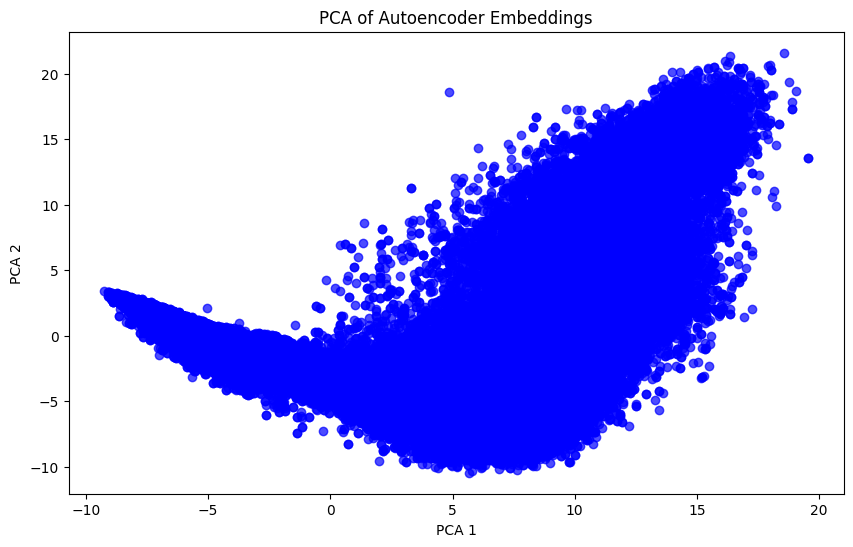

In [16]:
# Visualizzazione con PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(embeddings_np)

plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c='blue', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Autoencoder Embeddings')
plt.show()